## Overview

Plots and stats for the E Coli dataset, after removing outliers, before sequence clustering.

## Imports

In [34]:
from subpred.transporter_dataset import create_dataset
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    get_clusters,
    corr_heatmap,
    pca_plot_2d,
    pca_plot_3d,
    perform_pca,
    feature_importance_plot,
)
from subpred.util import get_protein_feature_stats
from subpred.pssm import calculate_pssms_notebook

## Creating the dataset

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    outliers= ['P76773', 'Q47706', 'P02943', 'P75733', 'P69856'],
    verbose = True,
    tax_ids_filter = [83333],
    output_log = "../logs/ecoli_amino_sugar_dataset.log",
)

In [3]:
df.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P69801,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,manY pel ptsP b1818 JW1807,PTS system mannose-specific EIIC component (EI...,4.A.6.1.1,4.A,83333,MEITTLQIVLVFIVACIAGMGSILDEFQFHRPLIACTLVGIVLGDM...
P36672,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,treB b4240 JW4199,PTS system trehalose-specific EIIBC component ...,4.A.1.2.4,4.A,83333,MMSKINQTDIDRLIELVGGRGNIATVSHCITRLRFVLNQPANARPK...
P56580,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlE gutA gutE b2703 JW5430,PTS system glucitol/sorbitol-specific EIIB com...,4.A.4.1.1,4.A,83333,MTHIRIEKGTGGWGGPLELKATPGKKIVYITAGTRPAIVDKLAQLT...
P0AA47,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,plaP yeeF b2014 JW5330,Low-affinity putrescine importer PlaP,2.A.3.1.14,2.A,83333,MSHNVTPNTSRVELRKTLTLVPVVMMGLAYMQPMTLFDTFGIVSGL...
P08722,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,bglF bglC bglS b3722 JW3700,PTS system beta-glucoside-specific EIIBCA comp...,4.A.1.2.2,4.A,83333,MTELARKIVAGVGGADNIVSLMHCATRLRFKLKDESKAQAEVLKKT...


### Stats

Imbalanced dataset, but enough samples per class. No transporters with two known substrates.

In [4]:
df.keywords_transport.value_counts()


Amino-acid transport    52
Sugar transport         48
Name: keywords_transport, dtype: int64

In [5]:
df.keywords_location.value_counts()


Cell inner membrane;Cell membrane;Membrane;Transmembrane    99
Cell membrane;Membrane;Transmembrane                         1
Name: keywords_location, dtype: int64

In [6]:
df.keywords_transport_related.value_counts()


Transport                     80
Symport;Transport             15
Antiport;Transport             4
Antiport;Symport;Transport     1
Name: keywords_transport_related, dtype: int64

#### TCDB


In [7]:
df.tcdb_class.value_counts()


2.A    55
3.A    23
4.A    17
0.0     5
Name: tcdb_class, dtype: int64

## Feature generation

In [8]:
labels = df.keywords_transport.rename("label").copy()
df_aac = calculate_aac(sequences=df.sequence)
df_paac = calculate_paac(sequences=df.sequence)

Hierarchical clustering can't quite distinguish all transporters into their categories, but there are two clusters with either more amino acid transporters or more sugar transporters:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7ff64d0d50d0>)

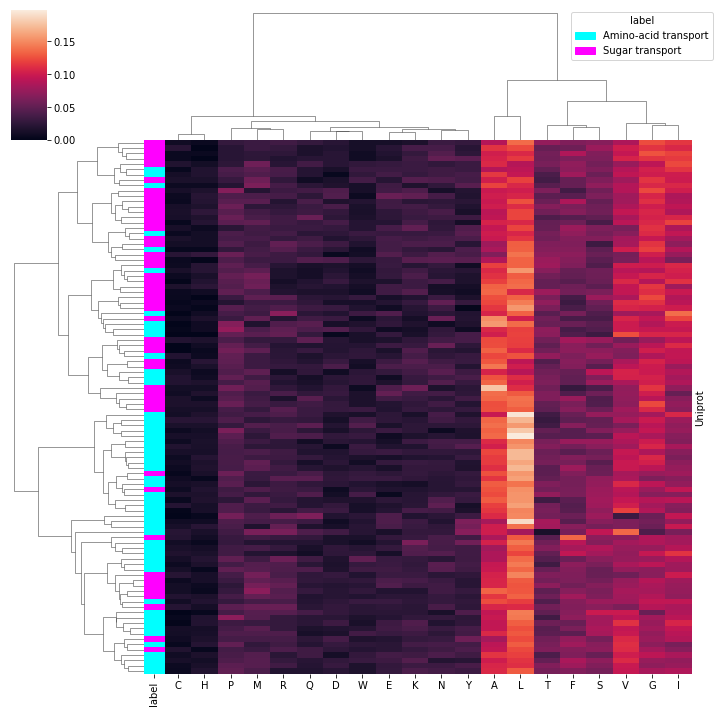

In [9]:
labeled_clustermap(df_aac, labels, xlabels="auto")

### PAAC plot

There are some sub-clusters that contain one substrate almost exclusively.

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7ff64bfbdac0>)

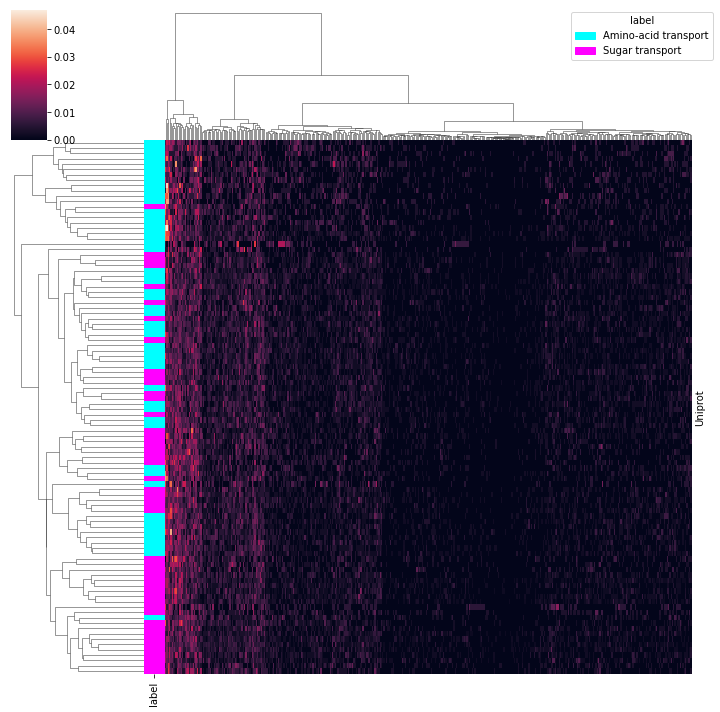

In [10]:
labeled_clustermap(df_paac, labels)

Again, there is a small cluster of transmembrane helix amino acids. However, the substrate specificity is often encoded in the remaining residues, so we will have to look at the feature importances first.

In [11]:
# cluster1 is the smaller one.
cluster0, cluster1 = get_clusters(df_paac.T, n_clusters=2)
from collections import Counter

print(len(cluster1))
counter = Counter()
for dipeptide in cluster1:
    counter[dipeptide[0]] += 1
    counter[dipeptide[1]] += 1

counter


28


Counter({'A': 10, 'G': 10, 'I': 10, 'L': 14, 'V': 8, 'F': 1, 'S': 2, 'T': 1})

#### Antiport, Symport, Uniport

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Symport;Transport': 'yellow',
  'Transport': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7ff62fe8f5e0>)

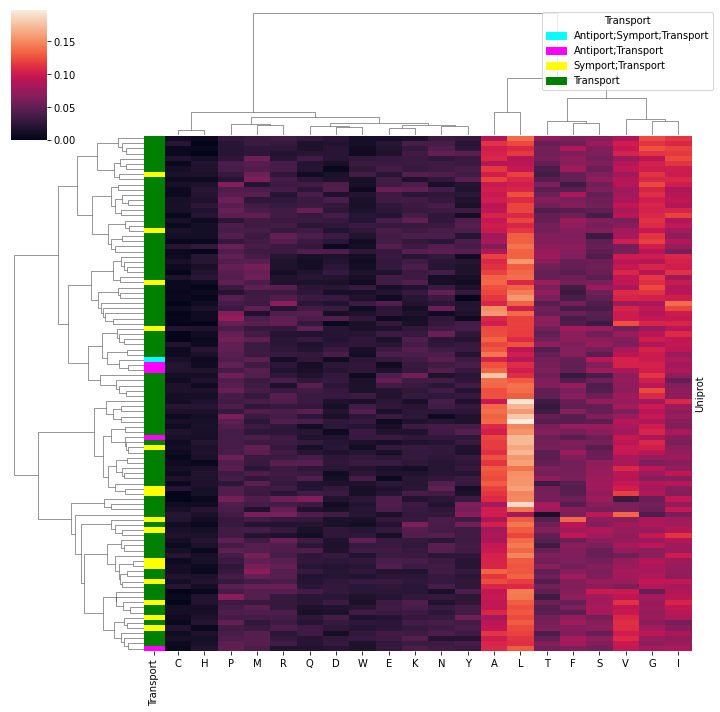

In [12]:
labeled_clustermap(
    df_aac, df.keywords_transport_related.rename("Transport"), xlabels="auto"
)

## Feature plots



#### Correlation

There do not seem to be any features that show a high correlation across all classes:

<AxesSubplot:>

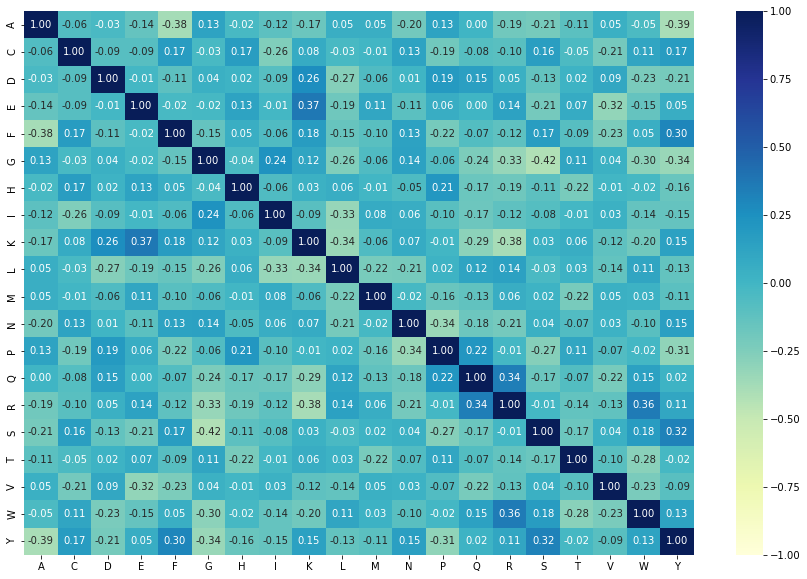

In [13]:
corr_heatmap(df_aac)

<AxesSubplot:>

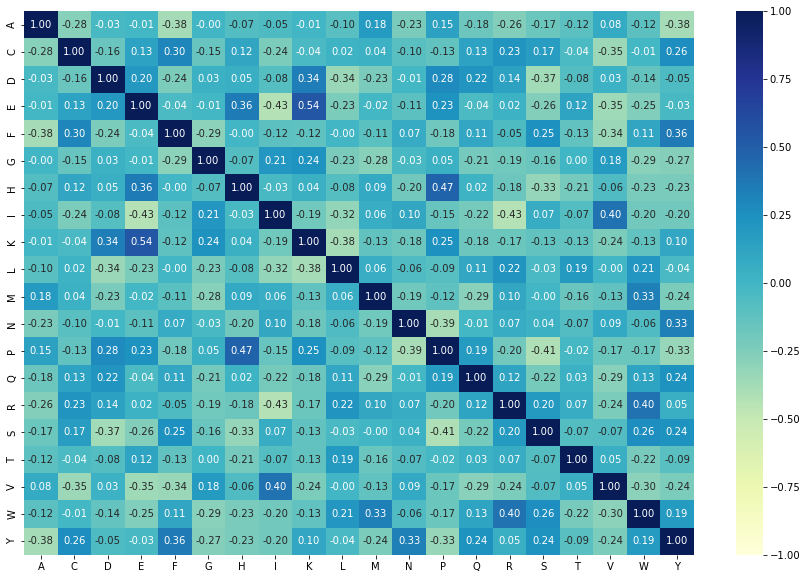

In [14]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Sugar transport"].index])

<AxesSubplot:>

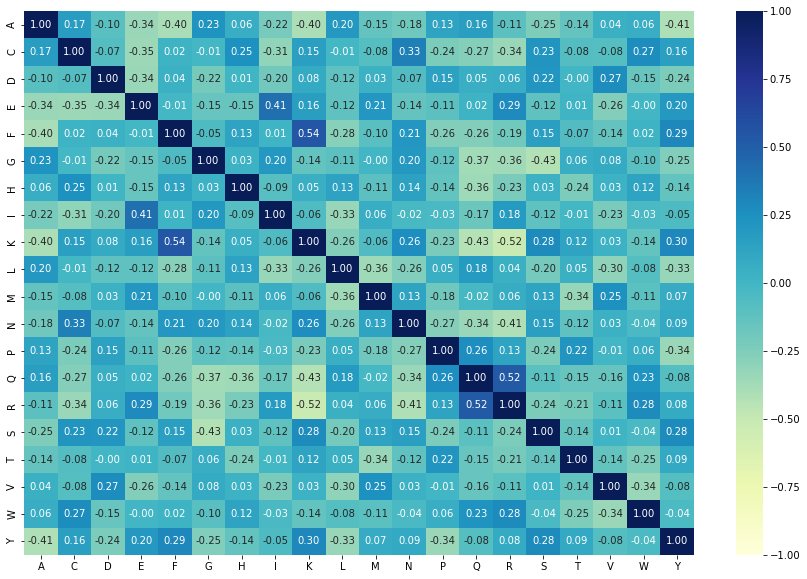

In [15]:
corr_heatmap(df_aac.loc[df[df.keywords_transport == "Amino-acid transport"].index])

#### Distribution

According to shapiro-wilk, the features now follow normal dist. Sample sizes for the dipeptides in PAAC is too low for a distribution test.

<AxesSubplot:>

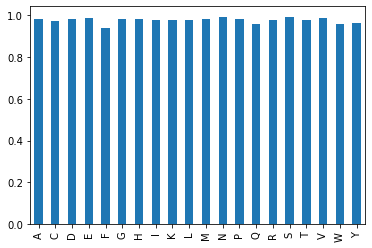

In [16]:
from scipy.stats import shapiro

df_aac.apply(shapiro).loc[0].plot.bar()

## Additional plots

### TCDB class

The non-2.A proteins mix well with the 2.A proteins, suggesting that they share a similar sequence composition

({'0.0': 'cyan', '2.A': 'magenta', '3.A': 'yellow', '4.A': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7ff632e65af0>)

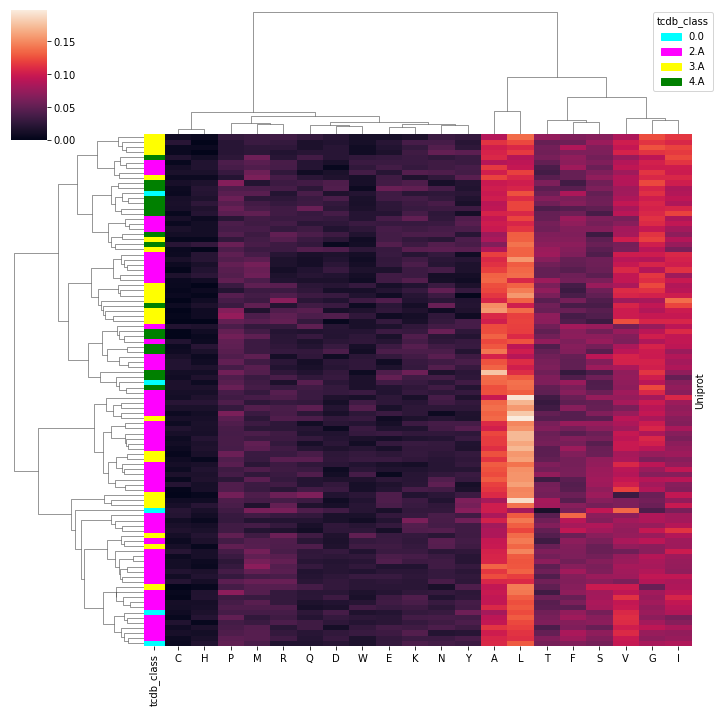

In [17]:
labeled_clustermap(df_aac, df.tcdb_class, xlabels="auto")


<AxesSubplot:>

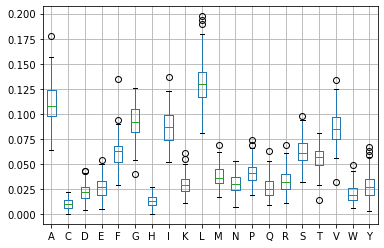

In [18]:
df_aac.boxplot()

## PCA plots

PCA plots for AAC and PAAC, the first two and three PC's.

### AAC

The data is not that clearly separable with just the AAC and the first two or thee PCs, but a pattern emerges.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

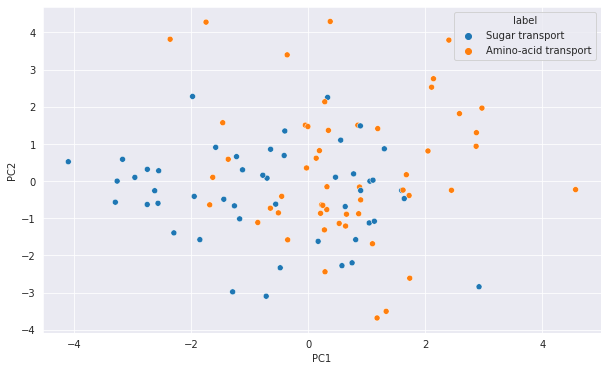

In [19]:
pca_plot_2d(df_aac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

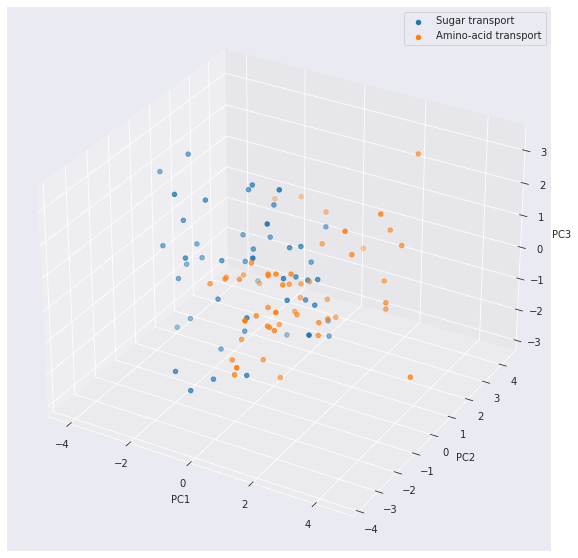

In [20]:
pca_plot_3d(df_aac, labels)

### PAAC


When looking at the dipeptides, two additional outliers seem to emerge:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

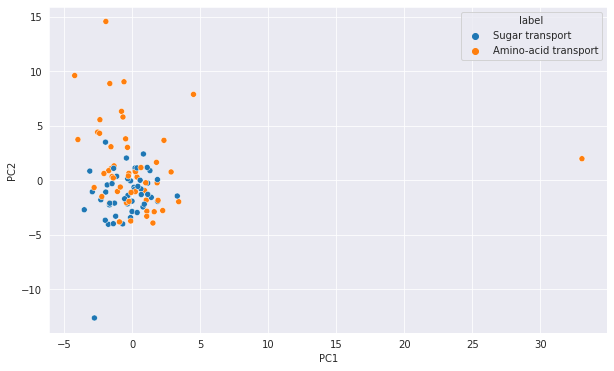

In [21]:
pca_plot_2d(df_paac, labels)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

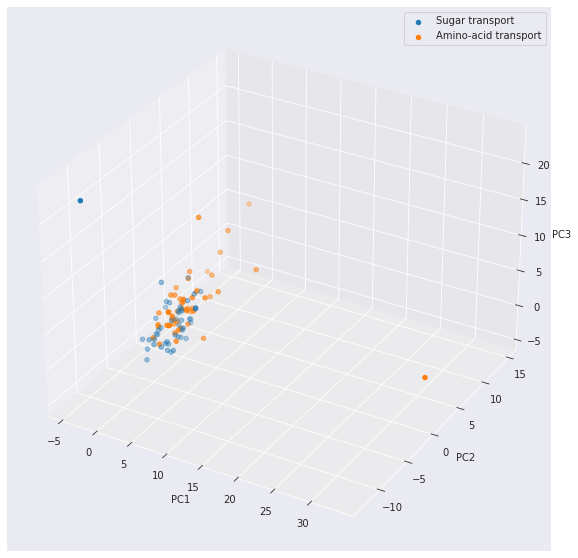

In [22]:
pca_plot_3d(df_paac, labels)


What proteins are those? 

In [32]:
df_pca = perform_pca(df_paac, labels)

display(df.loc[df_pca[df_pca.PC1 > 20].index])
display(df.loc[df_pca[df_pca.PC2 < -10].index])

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P64550,Amino-acid transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,alaE ygaW b2670 JW2645,L-alanine exporter AlaE,NaN,0.0,83333,MFSPQSRLRHAVADTFAMVVYCSVVNMCIEVFLSGMSFEQSFYSRL...


,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,tcdb_class,organism_id,sequence
Uniprot,,,,,,,,,
P56579,Sugar transport,Cell inner membrane;Cell membrane;Membrane;Tra...,Transport,srlA gutA sbl b2702 JW5429,PTS system glucitol/sorbitol-specific EIIC com...,4.A.4.1.1,4.A,83333,MIETITHGAEWFIGLFQKGGEVFTGMVTGILPLLISLLVIMNALIN...


When looking at their Uniprot pages, there is nothing that particularly stands out.

#### Analysis of the potential outlier P64550

How do these difference manifest in terms of features, for the AA transporter?

In [24]:
get_protein_feature_stats(df_paac, "P64550").round(3).head()

,P64550,mean_feature,std_feature,diff
VS,0.027,0.005,0.004,0.022
VV,0.027,0.008,0.005,0.019
QS,0.020,0.002,0.003,0.018
AD,0.020,0.002,0.003,0.018
VY,0.020,0.002,0.002,0.018


There seems to be an unusual amount of VS dipeptides (3), as well as VV (4) and QS (2).

In [25]:
get_protein_feature_stats(df_aac, "P64550").round(3)

,P64550,mean_feature,std_feature,diff
G,0.040,0.093,0.016,0.053
L,0.081,0.131,0.023,0.051
V,0.134,0.086,0.016,0.048
T,0.013,0.056,0.011,0.042
Y,0.067,0.028,0.011,0.039
S,0.094,0.061,0.013,0.033
R,0.060,0.032,0.011,0.028
I,0.060,0.087,0.017,0.027
M,0.060,0.038,0.011,0.022
Q,0.040,0.026,0.010,0.014


In terms of AAC, there is an unusually low amount of Glycine and Leucine, and an unusually high amount of Valine and Threonine. The associated publication is https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3131665/, where the gene is called *ygaW*. They conclude that this amino acid exporter is a member of a new protein family, with no known relatives (except for homologues in other organisms). 

#### Analysis of P56579

For this transporter, the differences are not as big. According to the TCDB, it is a group translocator, but not the only one in the dataset. According to BLAST, its closest relative in E coli has a smilarity of 36% and E value of 5.4. Therefore, this seems to be an outlier in terms of sequence. Is it also an outlier in the PSSM dataset?

In [29]:
get_protein_feature_stats(df_paac, "P56579").round(3).head()

,P56579,mean_feature,std_feature,diff
NP,0.016,0.002,0.002,0.015
SY,0.016,0.002,0.002,0.014
VT,0.016,0.004,0.003,0.012
YL,0.016,0.004,0.004,0.012
VL,0.000,0.011,0.005,0.011


In [30]:
get_protein_feature_stats(df_aac, "P56579").round(3)

,P56579,mean_feature,std_feature,diff
A,0.064,0.111,0.018,0.047
V,0.059,0.087,0.017,0.028
E,0.043,0.026,0.010,0.017
D,0.005,0.022,0.008,0.017
H,0.027,0.012,0.006,0.014
T,0.070,0.055,0.012,0.014
P,0.053,0.040,0.011,0.013
N,0.043,0.030,0.010,0.013
I,0.075,0.087,0.017,0.012
C,0.021,0.010,0.006,0.012


### PCA of PSSM

 Are the two outliers in terms of sequence also outliers for PSSM dataset?

In [48]:
df_pssm = calculate_pssms_notebook(df.sequence)
import pandas as pd

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

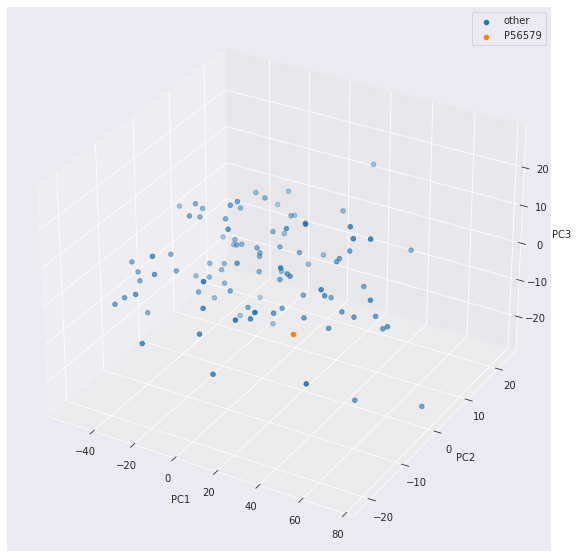

In [49]:
pca_plot_3d(df_pssm, pd.Series(["P56579" if x == "P56579" else "other" for x in df.index], index=df.index))

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

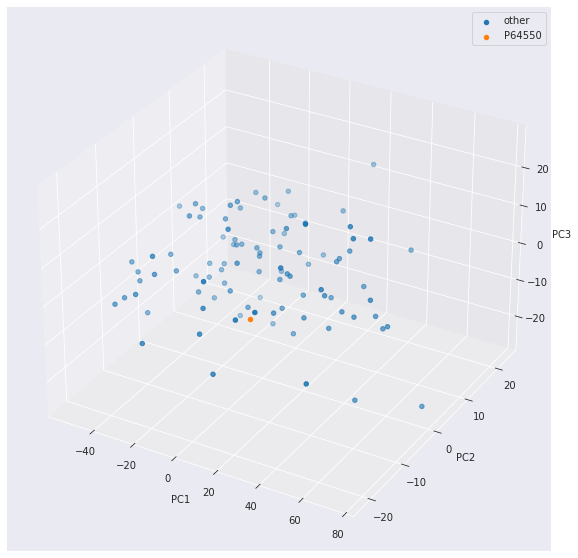

In [50]:
pca_plot_3d(df_pssm, pd.Series(["P64550" if x == "P64550" else "other" for x in df.index], index=df.index))

No, that does not seem to be the case! I will keep them in the dataset for now, and see if removing them makes a difference for AAC and PAAC. The dataset is also not clustered yet, maybe that will change something.

## F score Plot

In case of E. coli, the pattern that 

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

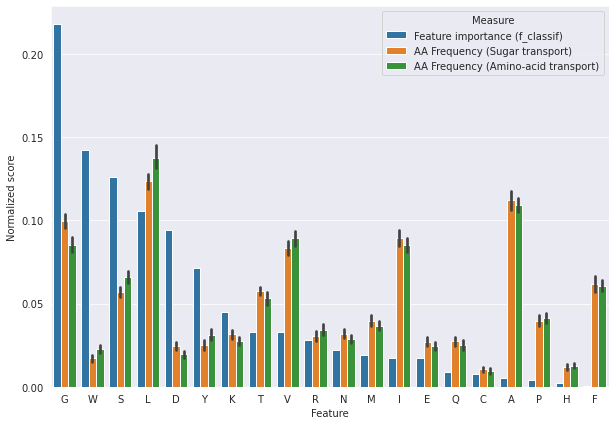

In [ ]:
feature_importance_plot(df_aac, labels, method="f_classif")

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

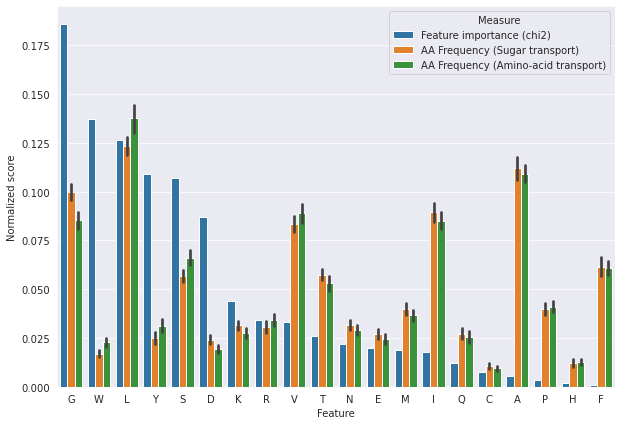

In [ ]:
feature_importance_plot(df_aac, labels, method="chi2")